In [4]:
import argparse
import numpy as np
np.random.seed(1113)
from APES import *
from time import time
from buffer import BufferLSTM as Buffer
import os
import matplotlib.pyplot as plt

### average steps needed to reach food.


In [5]:
np.average(np.hstack((np.arange(1,6),np.arange(2,6))))

3.2222222222222223

### Build and test the environment

In [6]:
rwrdschem=[-10,1000,-0.1]
svision=180
naction=0
Ego=False
max_timesteps=100
Level=1

In [8]:
ego_action_map = dict.fromkeys([(0,'N'), (1,'S'), (2,'W'),(3,'E')], Settings.PossibleActions[0])
ego_action_map.update(dict.fromkeys([(0,'S'), (1,'N'), (2,'E'),(3,'W')],Settings.PossibleActions[1] ))
ego_action_map.update(dict.fromkeys([(0,'E'), (1,'W'), (2,'N'),(3,'S')],Settings.PossibleActions[3]))
ego_action_map.update(dict.fromkeys([(0,'W'), (1,'E'), (2,'S'),(3,'N')], Settings.PossibleActions[2]))
ego_action_map.update(dict.fromkeys([(4,'W'), (4,'E'), (4,'S'),(4,'N')], Settings.PossibleActions[4]))

def New_Reward_Function(agents,foods,rwrdschem,world,AES,Terminated):
    """Calculate All agents rewards
    Args:
        * agents: dictionary of agents contain all agents by ID
        * foods: dictionary of all foods
        * rwrdschem: Reward Schema (More info in World __init__)
        * world: World Map
        * AES: one element array
    TODO:
        * copy this function to class or __init__ documentation as example of how to build customer reward function
        * Assign Reward To Agents
        * Impelent the Food Reward Part depending on the decision of who take the food reward if two 
          agent exist in food range in same time
        * Change All Ranges to .ControlRange not (-1) it's -1 only for testing purpuse
        * Change Punish per step to not punish when agent do nothing"""
    def ResetagentReward(ID):
        #Punish for step 
        agents[ID].CurrentReward= rwrdschem[2] # -1 # rwrdschem[2] if len(agents[ID].NextAction)>0 else 0

    for x in agents:
        ResetagentReward(x)

    AvailableFoods = world[(world>2000)&(world<=3000)]
    if len(AvailableFoods)==0:
        AES[0]-=1
        Terminated[0]= True if AES[0]<=0 else Terminated[0]
    for ID in agents.keys():
        if agents[ID].IAteFoodID >-1:
            agents[ID].CurrentReward+= foods[agents[ID].IAteFoodID].Energy* rwrdschem[1]
        agntcenter = World._GetElementCoords(ID,agents[ID].FullEgoCentric)
        aborder = World._GetVisionBorders(agntcenter,agents[ID].ControlRange,agents[ID].FullEgoCentric.shape)

def SetupEnvironment():
    Start = time()
    #Add Pictures
    Settings.SetBlockSize(20)
    Settings.AddImage('Wall','APES/Pics/wall.jpg')
    Settings.AddImage('Food','APES/Pics/food.jpg')
    #Specify World Size
    
    if Ego: 
        Settings.WorldSize=(11,11)

    #If the map is allocentric, we use larger word to compensate for the extra input in the ego-centric.
    else:
        
        Settings.WorldSize=(11,11)
        
    blue_Ag_PM = np.zeros(Settings.WorldSize)
    blue_Ag_PM[:Settings.WorldSize[0]-1,0] = 1
    #Create Probabilities

    
    red_Ag_PM = np.zeros(Settings.WorldSize)
    
    food_PM = np.zeros(Settings.WorldSize)
    
    blue_Ag_PM[:,0] =1
    red_Ag_PM[3:8,3:8]=1
    food_PM[3:8,3:8] = 1
    #Add Probabilities to Settings
    Settings.AddProbabilityDistribution('red_Ag_PM',red_Ag_PM)
    Settings.AddProbabilityDistribution('blue_Ag_PM',blue_Ag_PM)
    Settings.AddProbabilityDistribution('food_PM',food_PM)
    
    #Create World Elements
    food = Foods('Food',PdstName='food_PM')
    
    blue_Ag = Agent(Fname='APES/Pics/blue.jpg',
                    Power=3,
                    VisionAngle=svision,Range=-1,
                    PdstName='blue_Ag_PM',
                    ActionMemory=naction,
                   EgoCentric=Ego)
    red_Ag = Agent(Fname='APES/Pics/red.jpg',
                   VisionAngle=180,Range=-1,
                   Power=10,
                   ControlRange=1,
                   PdstName='red_Ag_PM')
    print(blue_Ag.ID,red_Ag.ID)
    game=World(RewardsScheme=rwrdschem,StepsLimit=max_timesteps,RewardFunction=New_Reward_Function)
    #Agents added first has priority of executing there actions first.
    #game.AddAgents([ragnt])
    game.AddAgents([red_Ag,blue_Ag])
    game.AddFoods([food])
    Start = time()-Start
    print ('Taken:',Start)
    return game

In [9]:
game=SetupEnvironment()
AIAgent = game.agents[list(game.agents.keys())[1]]

1001 1002
Taken: 2.8738136291503906


In [10]:
np.set_printoptions(2)

In [46]:
print(Settings.ProbabilitiesTable['red_Ag_PM'].reshape(Settings.WorldSize))

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.04 0.04 0.04 0.04 0.04 0.   0.   0.  ]
 [0.   0.   0.   0.04 0.04 0.04 0.04 0.04 0.   0.   0.  ]
 [0.   0.   0.   0.04 0.04 0.04 0.04 0.04 0.   0.   0.  ]
 [0.   0.   0.   0.04 0.04 0.04 0.04 0.04 0.   0.   0.  ]
 [0.   0.   0.   0.04 0.04 0.04 0.04 0.04 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


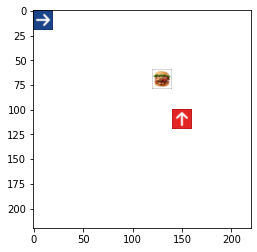

In [39]:
game.GenerateWorld()
game.agents[list(game.agents.keys())[1]].Direction='E'
AIAgent.NextAction=[]#
plt.imshow(game.BuildImage())